#### Imports etc

In [1]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
input_dim = len(list_features)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from traffic.core import Flight, Traffic

from trajectory_clustering.feature_preparation import fit_scaler, prepare_features, traffic_from_features

import wandb
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.autonotebook import tqdm


np.random.seed(0)

torch.manual_seed(0)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")


/var/folders/6r/vdmz5zjj6_d8769grj_ht__80000gn/T/ipykernel_2208/2398213321.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Get features

In [4]:
t_f = t.query("runway_name == '28'")
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [5]:
scaler = fit_scaler(t_f.data[list_features].to_numpy())
scaler.data_range_, scaler.data_min_, scaler.data_max_

(array([0.025886, 0.026745]),
 array([ 8.544617, 47.440933]),
 array([ 8.570503, 47.467678]))

In [6]:
t_f.data[list_features].to_numpy().shape

(167488, 2)

In [7]:
X, flight_order = prepare_features(t_f, list_features, scaler)
X
display(X)
display(X.reshape((X.shape[0], 64, len(list_features))))

array([[-0.1233099 ,  0.59521407, -0.13659893, ...,  0.17674331,
         0.866337  ,  0.18003365],
       [-0.1684308 ,  0.6174986 , -0.17569342, ...,  0.2714152 ,
         0.7207757 ,  0.2714152 ],
       [-0.13791238,  0.6106188 , -0.1457931 , ...,  0.17584595,
         0.87035465,  0.18003365],
       ...,
       [-0.04921579,  0.00512245, -0.04643437, ...,  0.17741634,
         0.9139303 ,  0.1783137 ],
       [-0.09549563, -0.00213124, -0.09147802, ...,  0.17569639,
         0.9030364 ,  0.1783137 ],
       [ 0.05833269,  0.05522528,  0.07185351, ...,  0.17928585,
         0.9629143 ,  0.18018322]], dtype=float32)

array([[[-0.1233099 ,  0.59521407],
        [-0.13659893,  0.6088989 ],
        [-0.15514177,  0.6131613 ],
        ...,
        [ 0.9261377 ,  0.17651898],
        [ 0.9231245 ,  0.17674331],
        [ 0.866337  ,  0.18003365]],

       [[-0.1684308 ,  0.6174986 ],
        [-0.17569342,  0.6186203 ],
        [-0.17569342,  0.61779773],
        ...,
        [ 0.7207757 ,  0.2714152 ],
        [ 0.7207757 ,  0.2714152 ],
        [ 0.7207757 ,  0.2714152 ]],

       [[-0.13791238,  0.6106188 ],
        [-0.1457931 ,  0.6134605 ],
        [-0.15259214,  0.6134605 ],
        ...,
        [ 0.9788303 ,  0.18100579],
        [ 0.9337093 ,  0.17584595],
        [ 0.87035465,  0.18003365]],

       ...,

       [[-0.04921579,  0.00512245],
        [-0.04643437,  0.01925594],
        [-0.04233949,  0.03907272],
        ...,
        [ 0.9356409 ,  0.17741634],
        [ 0.9356409 ,  0.17741634],
        [ 0.9139303 ,  0.1783137 ]],

       [[-0.09549563, -0.00213124],
        [-0.09147802,  0.02

#### Convolutional Autoencoder

In [10]:
X.shape

(2617, 128)

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(
        self,
        nb_features,
        nb_samples,
    ):
        

In [8]:
# Define the autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim: int = 2):
        super(ConvAutoencoder, self).__init__()

        self.relu = nn.LeakyReLU()
        # self.norm = torch.distributions.MixtureSameFamily
        self.norm = torch.distributions.Normal(0, 1)

        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            # input dimension: (batch_size, 2, 64)
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, padding=2),
            # out dimension: (batch_size, 16, 64)
            self.relu,
            nn.MaxPool1d(kernel_size=2, stride=2),
            # out dimension: (batch_size, 16, 32)
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=5, padding=2),
            # out dimension: (batch_size, 8, 32)
            self.relu,
            nn.MaxPool1d(kernel_size=2, stride=2),
            # out dimension: (batch_size, 8, 16)
            nn.Conv1d(in_channels=8, out_channels=4, kernel_size=5, padding=2),
            # out dimension: (batch_size, 4, 16)
            self.relu,
            nn.MaxPool1d(kernel_size=2, stride=2),
            # out dimension: (batch_size, 4, 8)
        )

        # Latent space layer
        self.latent_space = nn.Sequential(
            nn.Linear(8 * 4, 8),  # Adjust input size based on the previous layer's output size
            # nn.ReLU(True)
            self.relu,
            # nn.Linear(8, 2),
        )
        self.mu = nn.Linear(8, self.latent_dim)
        self.logvar = nn.Linear(8, self.latent_dim)

        self.decoder_1 = nn.Sequential(
            nn.Linear(self.latent_dim, 8),
            self.relu,
            nn.Linear(8, 8 * 4),  # Adjust output size based on the latent space size
            self.relu,
        )

        # Decoder layers
        self.decoder_2 = nn.Sequential(
            # input dimension: (batch_size, 4, 8)
            nn.ConvTranspose1d(
                in_channels=4,
                out_channels=8,
                kernel_size=3,
                padding=0,
                stride=2,
                output_padding=0,
            ),
            # output dimension: (batch_size, 8, 17)
            self.relu,
            nn.ConvTranspose1d(
                in_channels=8,
                out_channels=16,
                kernel_size=3,
                padding=0,
                stride=2,
                output_padding=0,
            ),
            # output dimension: (batch_size, 16, 35)
            self.relu,
            # nn.ConvTranspose1d(in_channels=16, out_channels=2, kernel_size=3, padding=0, stride=2, output_padding=0,),
            # output dimension: (batch_size, 2, 64)
            nn.Conv1d(in_channels=16, out_channels=2, kernel_size=5, padding=2),
            # self.relu,
            nn.Upsample(size=64, mode="nearest"),
            nn.Tanh(),
        )
        # out dimension: (batch_size, 2, 64)

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer

        x = self.latent_space(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        sigma = torch.exp(logvar)

        self.latent = mu.clone()

        z = mu + sigma * self.norm.sample(mu.shape).to(x.device)

        # x = self.decoder_1(x)
        x = self.decoder_1(z)
        x = x.view(x.size(0), -1, 8)  # Reshape for the convolutional decoder

        self.kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum()

        x = self.decoder_2(x)

        return x

In [126]:
Lin = 8
stride = 2
padding = 0
dilation = 1
kernel_size = 3
output_padding = 0

(Lin - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

17

In [104]:
cae

ConvAutoencoder(
  (relu): LeakyReLU(negative_slope=0.01)
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(8, 4, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (latent_space): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=8, out_features=3, bias=True)
  (logvar): Linear(in_features=8, out_features=3, bias=True)
  (decoder_1): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
  

In [26]:
X.shape

(2617, 128)

In [30]:
X.reshape(-1, 64, 2).shape

(2617, 64, 2)

In [9]:
display(X.reshape(-1, 64, 2).swapaxes(1, 2))
X.reshape(-1, 64, 2).swapaxes(1, 2).shape

X_reshaped = X.reshape(-1, 64, 2).swapaxes(1, 2)

array([[[-0.1233099 , -0.13659893, -0.15514177, ...,  0.9261377 ,
          0.9231245 ,  0.866337  ],
        [ 0.59521407,  0.6088989 ,  0.6131613 , ...,  0.17651898,
          0.17674331,  0.18003365]],

       [[-0.1684308 , -0.17569342, -0.17569342, ...,  0.7207757 ,
          0.7207757 ,  0.7207757 ],
        [ 0.6174986 ,  0.6186203 ,  0.61779773, ...,  0.2714152 ,
          0.2714152 ,  0.2714152 ]],

       [[-0.13791238, -0.1457931 , -0.15259214, ...,  0.9788303 ,
          0.9337093 ,  0.87035465],
        [ 0.6106188 ,  0.6134605 ,  0.6134605 , ...,  0.18100579,
          0.17584595,  0.18003365]],

       ...,

       [[-0.04921579, -0.04643437, -0.04233949, ...,  0.9356409 ,
          0.9356409 ,  0.9139303 ],
        [ 0.00512245,  0.01925594,  0.03907272, ...,  0.17741634,
          0.17741634,  0.1783137 ]],

       [[-0.09549563, -0.09147802, -0.09812254, ...,  0.9509387 ,
          0.9506297 ,  0.9030364 ],
        [-0.00213124,  0.02179847,  0.04154047, ...,  0.17584

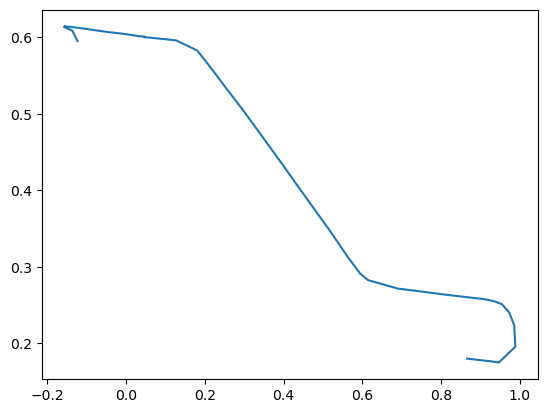

In [36]:
plt.plot(X_reshaped[0, 0, :], X_reshaped[0, 1, :])

In [10]:
cae = ConvAutoencoder()

Y = cae(torch.tensor(X_reshaped)).detach().numpy()
Y
Y.shape

(2617, 2, 64)

In [83]:
Y.shape

(2617, 2, 43)

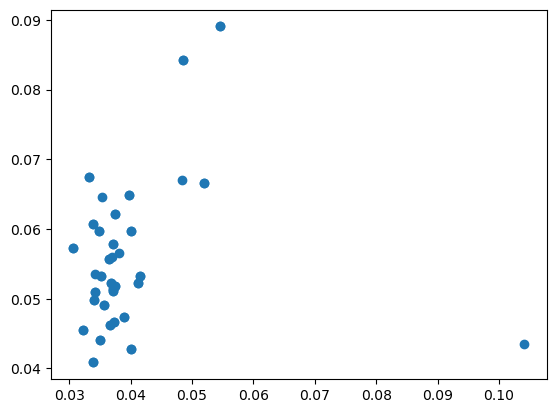

In [407]:
# Y = _.detach().cpu().numpy()

plt.scatter(Y[0, 0, :], Y[0, 1, :], )#c=labels, cmap="tab10", alpha=0.5)

In [14]:
DEVICE = "mps"


In [15]:

def train(model: ConvAutoencoder, X, epochs=500):
    model.to(DEVICE)
    model.train()
    with torch.enable_grad():
        criterion = nn.MSELoss(reduction="sum")
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(torch.Tensor(X))
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=300,
            shuffle=True,
            sampler=None,
            num_workers=6,
        )

        loss_evolution = []
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0
            for batch in tqdm(dataloader, desc="batches", leave=False, unit="batch"):
                v = batch[0].to(DEVICE)

                optimizer.zero_grad()
                output = model(v)
                loss_mse = criterion(output, v)

                loss_kl = model.kl
                loss = loss_mse + loss_kl * 0.05

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            if epoch % 5 == 0:
                print(epoch, epoch_loss)
            loss_evolution.append(epoch_loss)

    return model, loss_evolution

In [16]:
cae = ConvAutoencoder(latent_dim = 3)

model, loss= train(model=cae, X=X_reshaped, epochs=100)


  0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

0 61590.84326171875


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

5 37899.136474609375


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

10 24297.926635742188


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

15 20936.43115234375


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

20 13607.245483398438


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

25 12526.897094726562


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

30 11577.161193847656


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

35 9446.308654785156


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

40 7819.341064453125


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

45 6792.008972167969


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

50 6173.623046875


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

55 5769.26708984375


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

60 5357.942687988281


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

65 5106.698303222656


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

70 4907.997863769531


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

75 4692.685821533203


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

80 4494.771423339844


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

85 4313.952301025391


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

90 4182.448760986328


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

95 4028.9833374023438


batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

batches:   0%|          | 0/9 [00:00<?, ?batch/s]

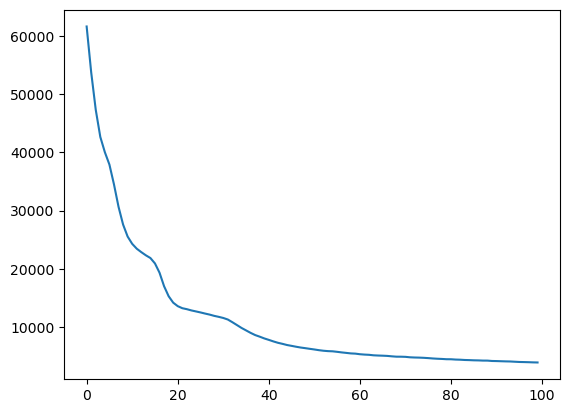

In [17]:
plt.plot(loss)

In [18]:
cae.to("cpu")
cae.eval()

Y = cae(torch.tensor(X_reshaped)).detach().numpy()
Y
Y.shape

(2617, 2, 64)

In [20]:
X.shape

X_original = X.copy()

X = X_reshaped.copy()

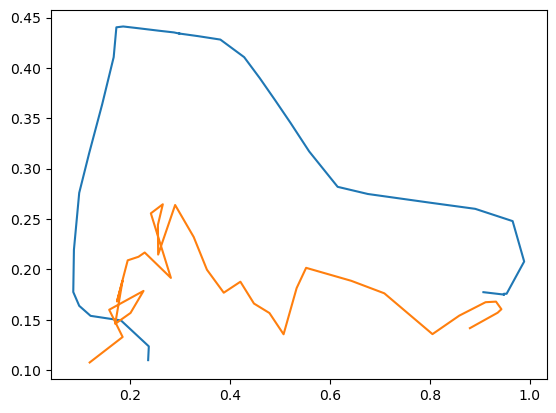

In [49]:
idx = np.random.randint(0, X.shape[0], size=1)[0]
# print(idx)

plt.plot(X[idx, 0, :], X[idx, 1, :])
plt.plot(Y[idx, 0, :], Y[idx, 1, :])

In [50]:
latent_space = cae.latent.detach().cpu().numpy()
latent_space.shape

(2617, 3)

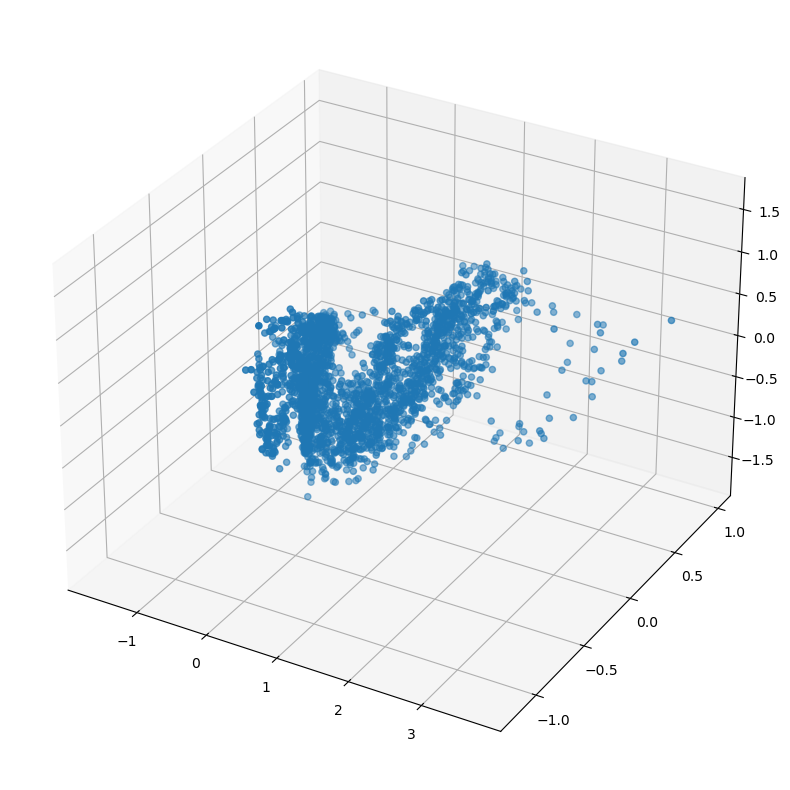

In [51]:
# 3d figure

plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
)

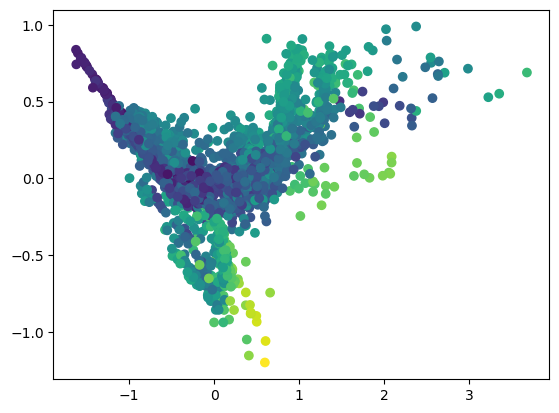

In [52]:
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=latent_space[:, 2], )

In [53]:
colormap = mpl.colormaps["Accent"]


In [105]:
from sklearn.mixture import GaussianMixture
latent = latent_space
clustering = GaussianMixture(n_components=4).fit(latent)
clusters = clustering.predict(latent)
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3]), array([898, 735, 648, 336]))

In [99]:
from sklearn.cluster import HDBSCAN

latent = latent_space
clustering = HDBSCAN(min_cluster_size=30, max_cluster_size=800).fit(latent)
clusters = clustering.labels_
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([1003,  246,  728,  583,   57]))

In [592]:
from sklearn.cluster import KMeans


latent = latent_space
clustering = KMeans(n_clusters=4).fit(latent)
clusters = clustering.predict(latent)
np.unique(clusters, return_counts=True)

/opt/homebrew/Caskroom/miniforge/base/envs/artefact/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3], dtype=int32), array([864, 907, 557, 289]))

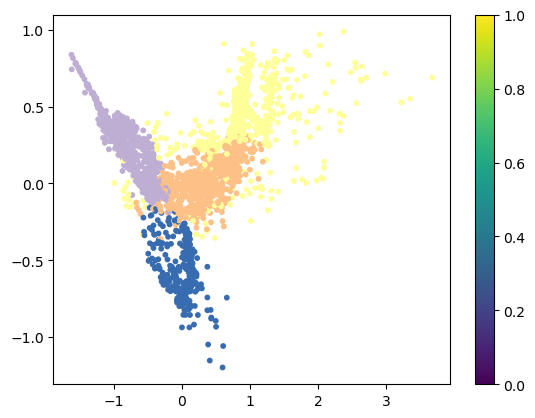

In [106]:
plt.scatter(latent[:, 0], latent[:, 1], c=[colormap(c+1) for c in clusters], s=10)
plt.colorbar()

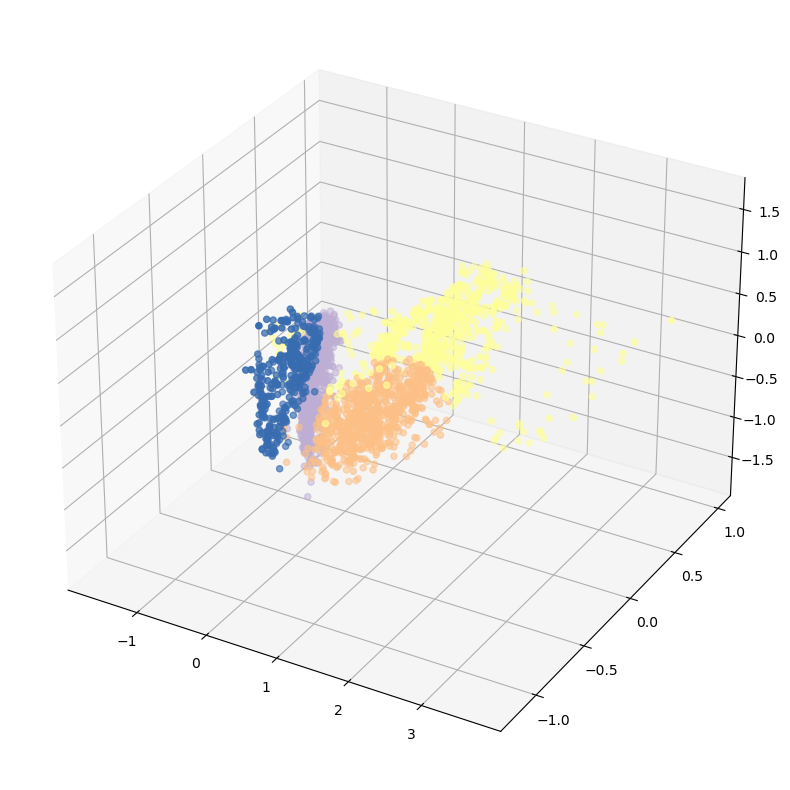

In [107]:
# %matplotlib widget
%matplotlib inline

plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[colormap(c+1) for c in clusters],
)

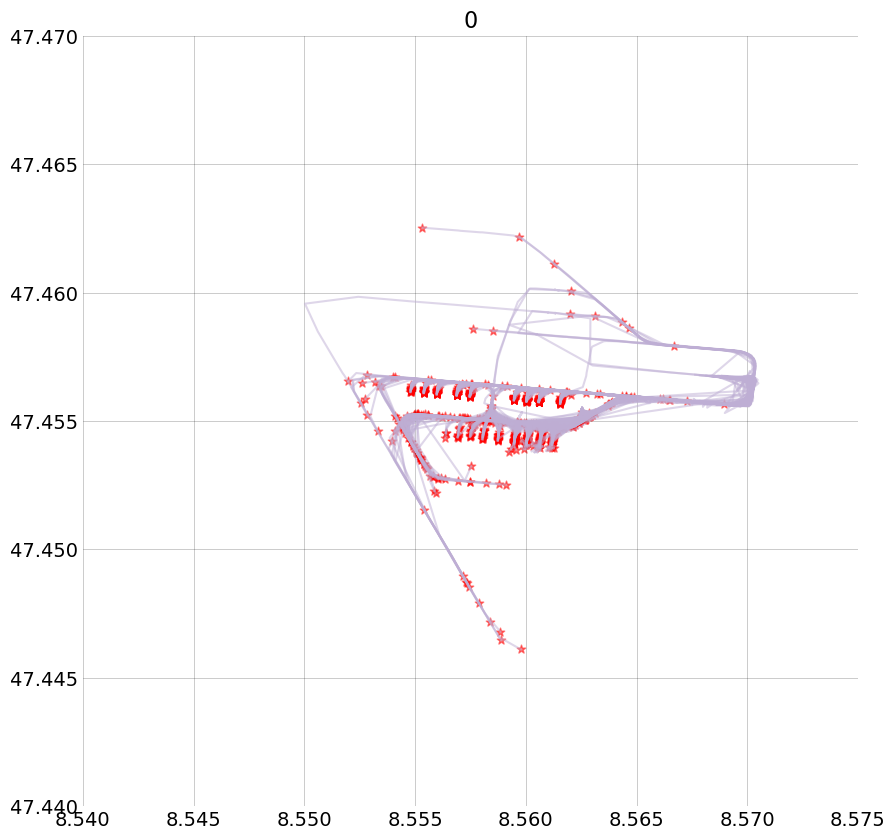

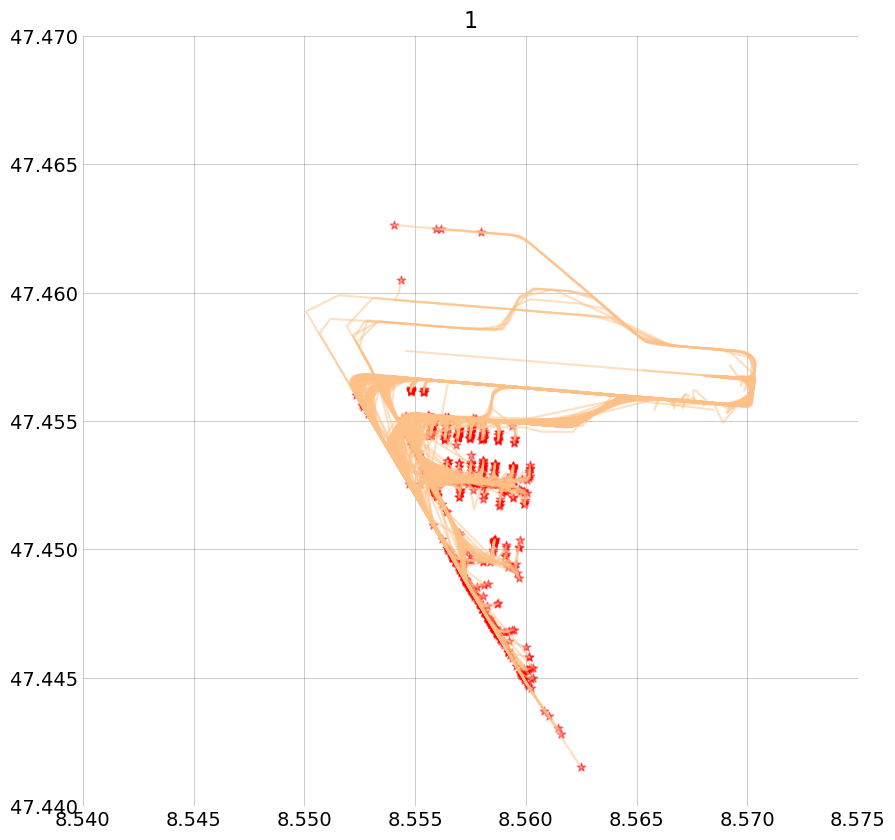

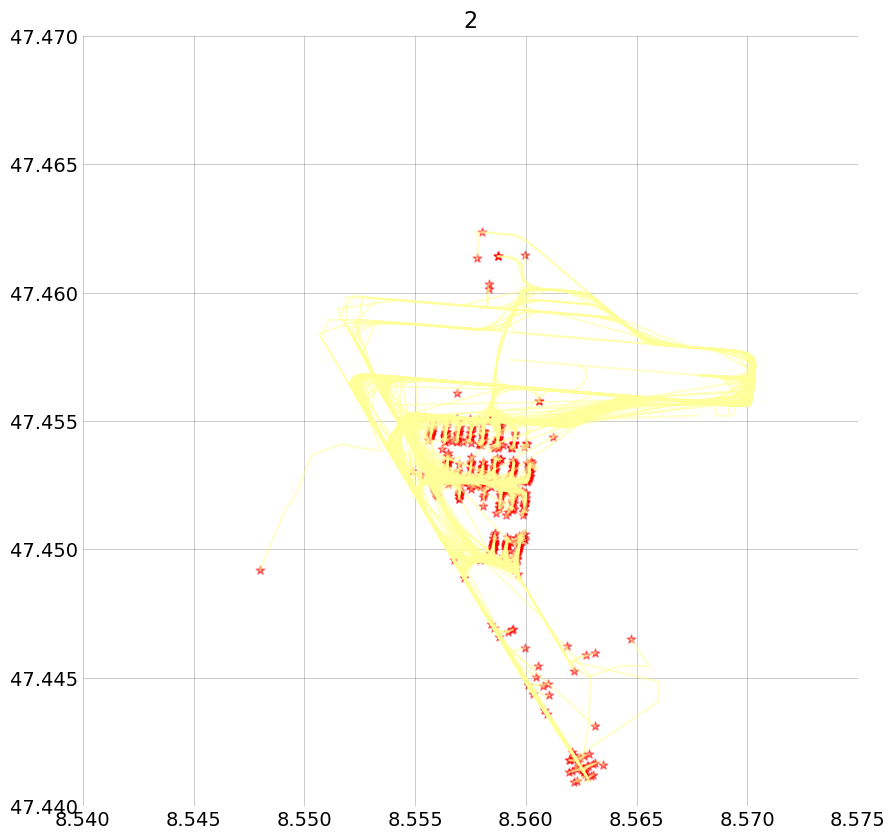

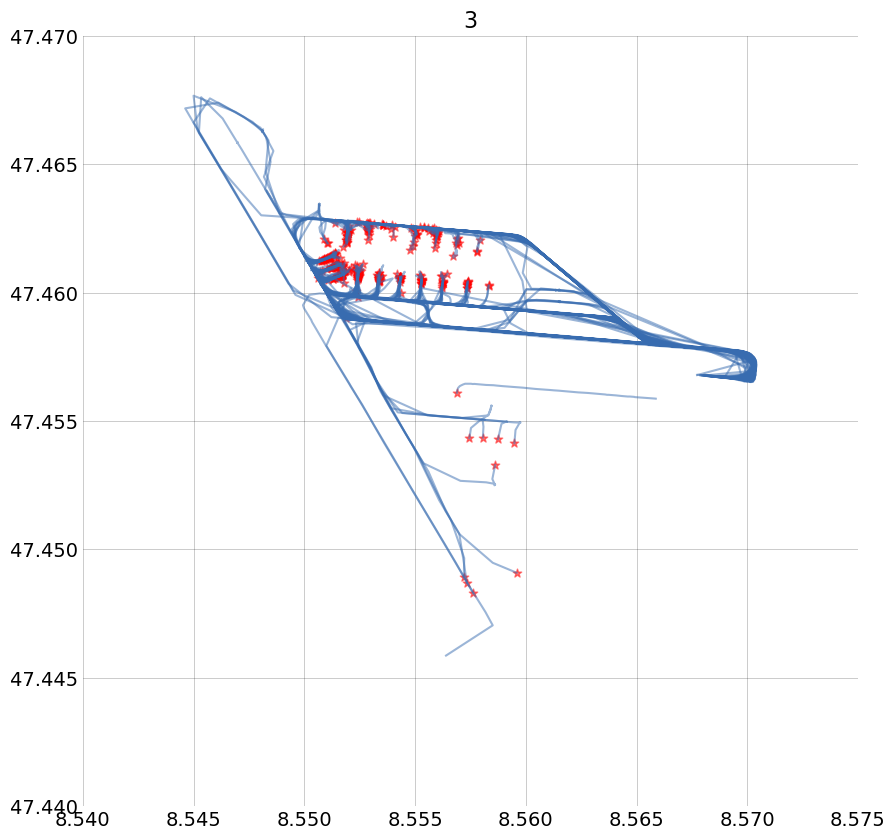

In [108]:
for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, flight_order):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )
            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster+1))
            ax.set_xlim(8.54, 8.575)
            ax.set_ylim(47.44, 47.47)
        
        plt.show()